<a href="https://colab.research.google.com/github/MehrdadJalali-AI/NodeGeneration/blob/main/NodeGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methods and Workflow

## Objective

In this project, we develop a **Conditional Generative Adversarial Network (cGAN)** to generate new Metal-Organic Frameworks (MOFs) by synthesizing both their graph structure (adjacency matrix) and material features (node-level descriptors). The generation is conditioned on two chemical factors:

- Metal type
- Linker type

---

## Step 1 - Data Preparation

The dataset includes:

- Numerical MOF descriptors from an Excel file (`Book1.xlsx`).
- Precomputed adjacency matrices from a CSV file (`adjacency_matrix.csv`).
- Numerical features are normalized using **Min-Max scaling**.
- Adjacency matrices are normalized using **Z-score normalization**.
- Metal and linker SMILES strings are encoded into integer labels using `LabelEncoder` to be used in the neural network.

---

## Step 2 - Tensor Construction

- All data (features, adjacency matrices, metal and linker labels) are converted into **PyTorch tensors**.
- Tensors are placed on **CPU** or **GPU**, depending on availability.

---

## Step 3 - Generator Architecture

The generator is conditioned on:

- A random latent vector sampled from a normal distribution.
- Embeddings of the metal and linker types.

The generator has a shared backbone followed by two output branches:

- One branch generates the **adjacency matrix**.
- Another branch generates the **MOF features**.

This structure allows the generator to produce both graph structure and material properties simultaneously.

---

## Step 4 - Critic (Discriminator) Architecture

The critic evaluates:

- Real or generated features.
- Real or generated adjacency matrix.
- Metal and Linker embeddings (as conditions).

The critic outputs a single **validity score** to distinguish real MOFs from generated ones.

---

## Step 5 - Loss Functions

- The model uses the **Wasserstein GAN loss** for stable adversarial training.
- A **gradient penalty** is applied to the critic (WGAN-GP) to enforce smoothness.
- Two additional **cosine similarity losses** are added:
    - One for **feature similarity**.
    - One for **adjacency similarity**.

This encourages the generator to produce MOFs close to real samples while still generating diverse structures.

---

## Step 6 - Training

- The generator and critic are trained **alternatively**.
- The generator aims to produce realistic MOFs conditioned on metal and linker types.
- The critic provides feedback on how distinguishable the generated MOFs are.
- **Early stopping** is used when no improvement in similarity is observed.

---

## Step 7 - MOF Generation

After training:

- Latent vectors and random valid metal-linker pairs are sampled.
- The generator produces:
    - A new **adjacency matrix**.
    - New **MOF features**.
- Similarity between generated and real MOFs is measured.
- The generated MOFs are saved as a **JSON** file for further analysis.

---

## Notes

- This approach guarantees that generated MOFs are conditioned on **domain knowledge**.
- It helps generate **chemically valid**, **realistic**, and **diverse** MOF structures.


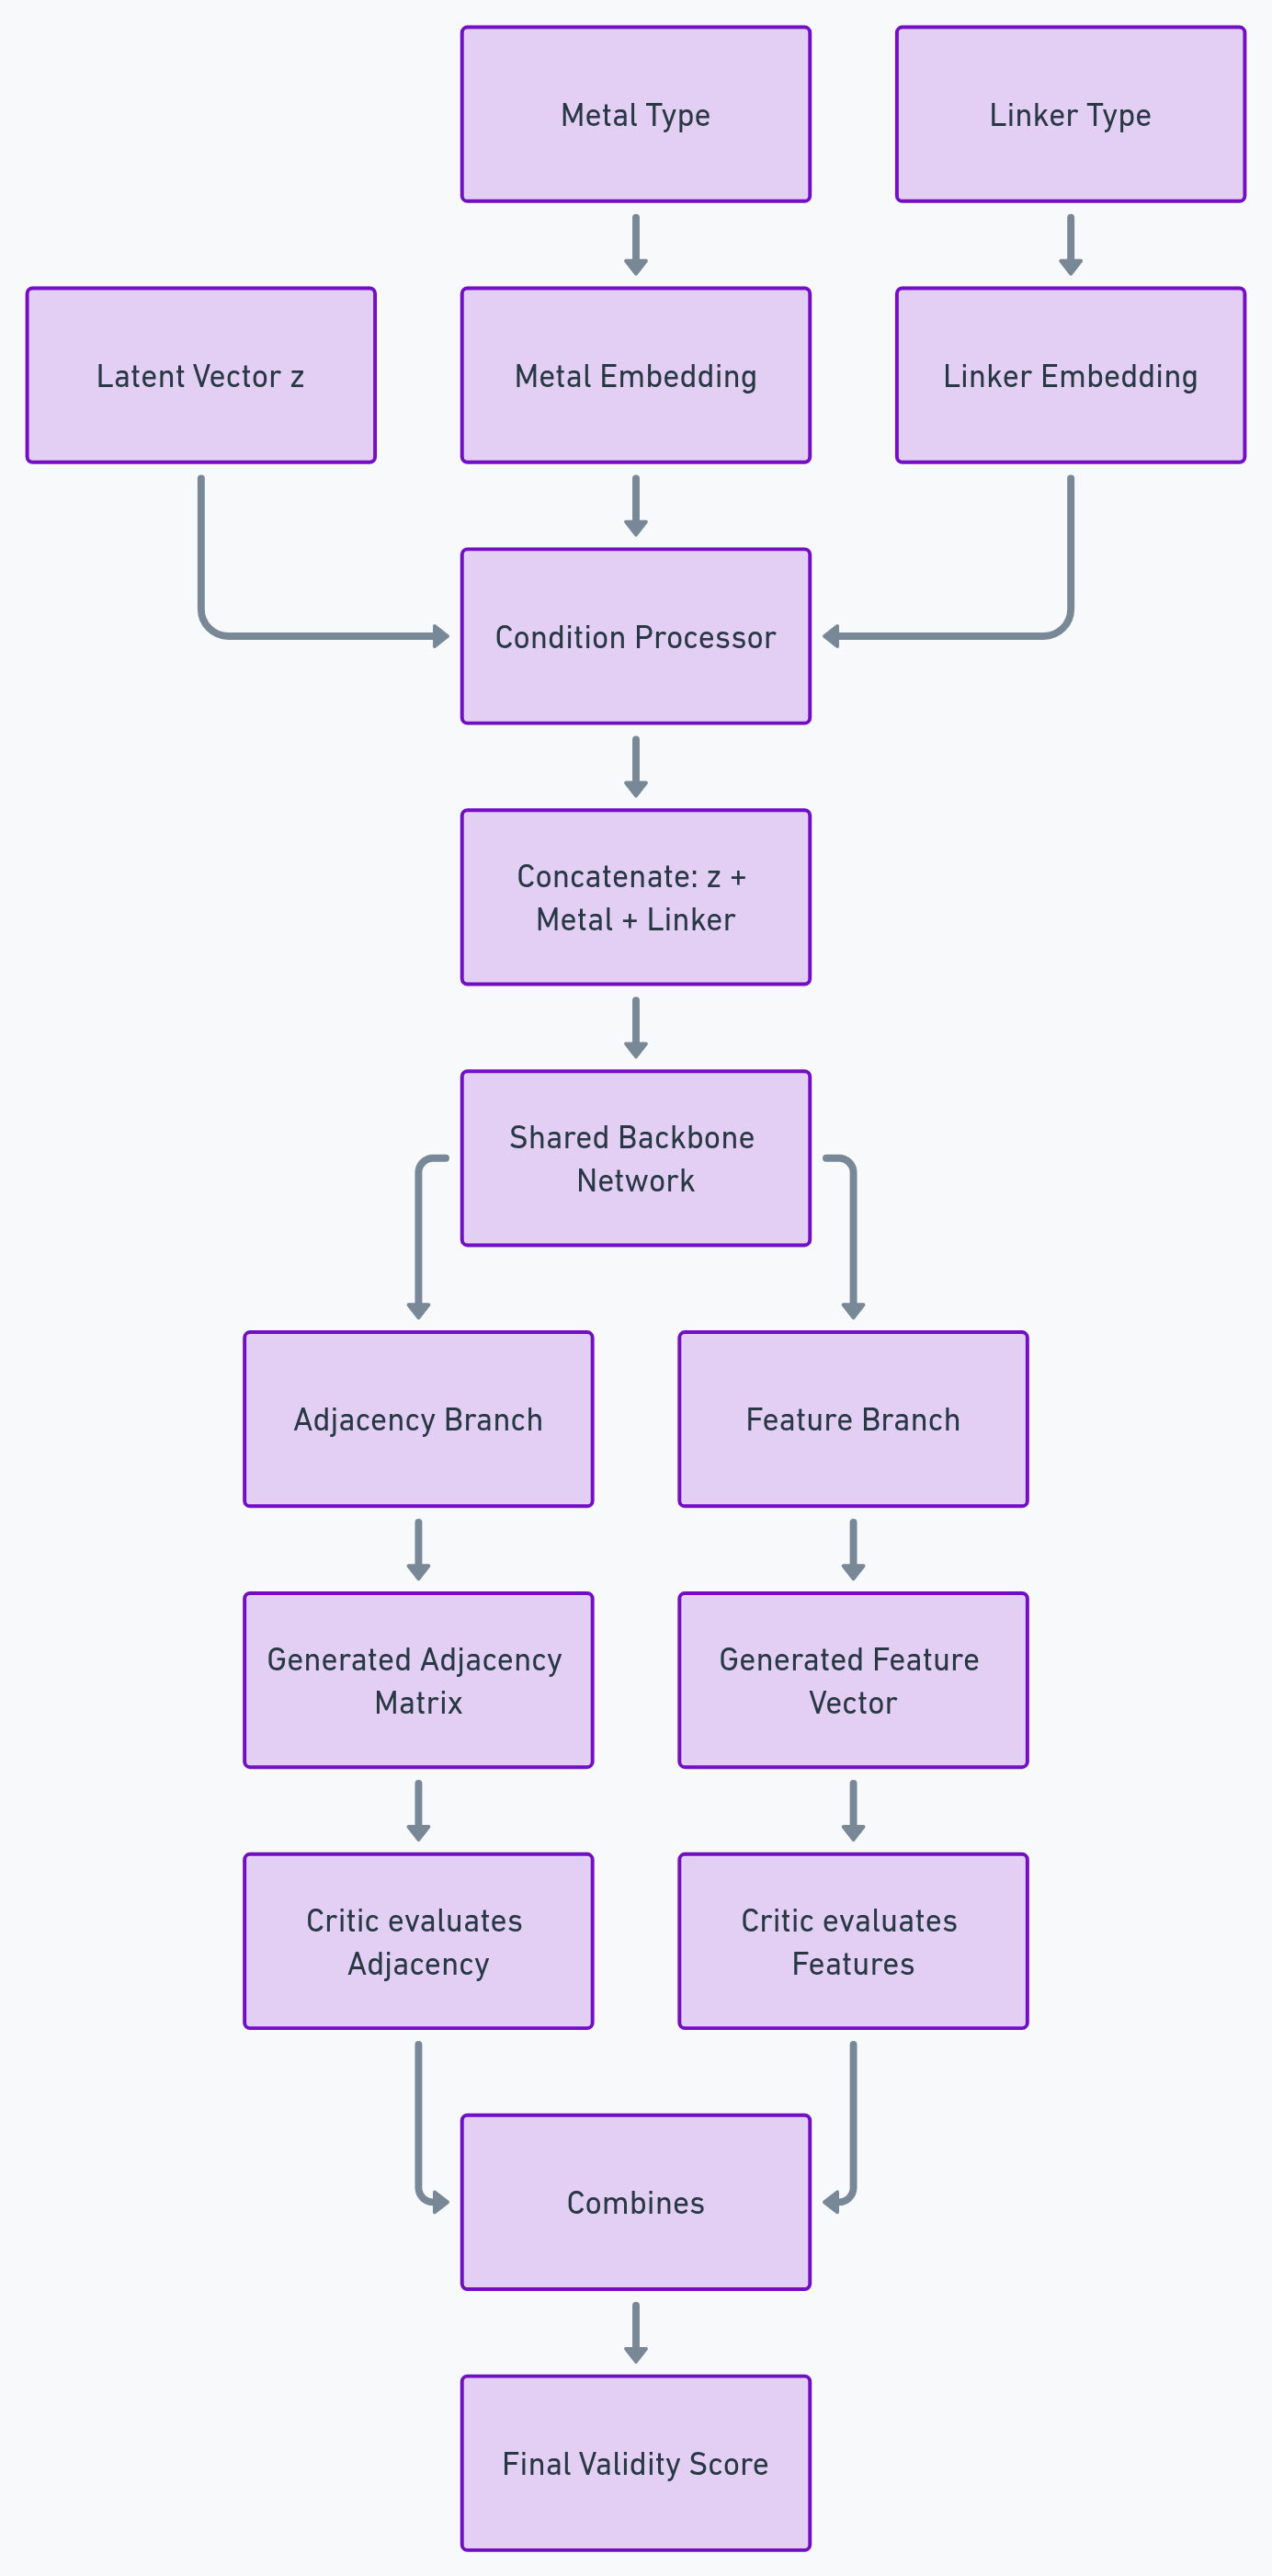



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import spectral_norm
from sklearn.preprocessing import LabelEncoder
import json
from torch.nn.functional import cosine_similarity

# تنظیم دستگاه (GPU یا CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# بارگذاری و پیش‌پردازش داده‌ها
mof_data = pd.read_excel("Book1.xlsx")
numeric_cols = ['max_metal_coordination_n', 'n_sbu_point_of_extension', 'n_linker_point_of_extension',
                'n_channel', 'void_fraction', 'asa (A^2)', 'av (A^3)', 'pld (A)', 'lcd (A)', 'lfpd (A)']
features = mof_data[numeric_cols].values
refcodes = mof_data['Refcode'].values
metal_smiles = mof_data['metal_sbu_smile'].values
linker_smiles = mof_data['linker_smile'].values

adj_data = pd.read_csv("adjacency_matrix.csv")
adj_matrix = adj_data.drop(columns=['Refcode']).values
adj_refcodes = adj_data['Refcode'].values

# نرمال‌سازی داده‌ها به مقیاس 0 تا 1
features_min = features.min(axis=0)
features_max = features.max(axis=0)
features = (features - features_min) / (features_max - features_min)
adj_mean, adj_std = adj_matrix.mean(), adj_matrix.std()
adj_matrix = (adj_matrix - adj_mean) / adj_std

print("Features Min:", features_min)
print("Features Max:", features_max)
print("Adj Mean:", adj_mean)
print("Adj Std:", adj_std)

# تبدیل SMILES به اعداد
le_metal = LabelEncoder()
le_linker = LabelEncoder()
metal_encoded = le_metal.fit_transform(metal_smiles)
linker_encoded = le_linker.fit_transform(linker_smiles)

features_tensor = torch.FloatTensor(features).to(device)
adj_matrix_tensor = torch.FloatTensor(adj_matrix).to(device)
metal_tensor = torch.FloatTensor(metal_encoded).unsqueeze(1).to(device)
linker_tensor = torch.FloatTensor(linker_encoded).unsqueeze(1).to(device)


# تعریف مدل Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, metal_vocab_size, linker_vocab_size, embedding_dim, adj_dim, feature_dim):
        super(Generator, self).__init__()
        self.metal_embedding = nn.Embedding(metal_vocab_size, embedding_dim)
        self.linker_embedding = nn.Embedding(linker_vocab_size, embedding_dim)
        self.condition_processor = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(128)
        )
        self.shared = nn.Sequential(
            nn.Linear(latent_dim + 128, 512),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(1024),
            nn.Dropout(0.3)
        )
        self.adj_branch = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(4096),
            nn.Dropout(0.3),
            nn.Linear(4096, adj_dim),
        )
        self.feature_branch = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(256),
            nn.Linear(256, feature_dim),
        )

    def forward(self, z, metal_cond, linker_cond):
        metal_cond = metal_cond.squeeze().long()
        linker_cond = linker_cond.squeeze().long()
        if metal_cond.dim() == 0:
            metal_cond = metal_cond.unsqueeze(0)
        if linker_cond.dim() == 0:
            linker_cond = linker_cond.unsqueeze(0)
        metal_emb = self.metal_embedding(metal_cond)
        linker_emb = self.linker_embedding(linker_cond)
        cond = torch.cat([metal_emb, linker_emb], dim=1)
        cond_out = self.condition_processor(cond)
        combined = torch.cat([z, cond_out], dim=1)
        shared_out = self.shared(combined)
        adj_output = self.adj_branch(shared_out) * adj_std + adj_mean
        feature_output = self.feature_branch(shared_out)
        return adj_output, feature_output


# تعریف مدل Critic
class Critic(nn.Module):
    def __init__(self, feature_dim, adj_dim, condition_dim):
        super(Critic, self).__init__()
        self.feature_processor = nn.Sequential(
            spectral_norm(nn.Linear(feature_dim, 128)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(128, 64)),
            nn.LeakyReLU(0.2)
        )
        self.adj_processor = nn.Sequential(
            spectral_norm(nn.Linear(adj_dim, 256)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(256, 64)),
            nn.LeakyReLU(0.2)
        )
        self.condition_processor = nn.Sequential(
            spectral_norm(nn.Linear(condition_dim, 32)),
            nn.LeakyReLU(0.2)
        )
        self.combined = nn.Sequential(
            spectral_norm(nn.Linear(64 + 64 + 32, 32)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(32, 1)),
            nn.ConstantPad1d((0, 0), 50)  # افزایش Bias
        )

    def forward(self, features, adj, condition):
        noise = torch.randn_like(features) * 0.1
        feat_out = self.feature_processor(features + noise)
        adj_out = self.adj_processor(adj)
        cond_out = self.condition_processor(condition)
        combined = torch.cat([feat_out, adj_out, cond_out], dim=1)
        return self.combined(combined)


# محاسبه جریمه گرادیان
def compute_gradient_penalty(critic, real_features, real_adj, fake_features, fake_adj, real_cond, fake_cond):
    batch_size = real_features.size(0)
    alpha = torch.rand(batch_size, 1).to(device)
    interpolates_features = alpha * real_features + (1 - alpha) * fake_features
    interpolates_adj = alpha * real_adj + (1 - alpha) * fake_adj
    interpolates_cond = alpha * real_cond + (1 - alpha) * fake_cond

    interpolates_features.requires_grad_(True)
    interpolates_adj.requires_grad_(True)
    interpolates_cond.requires_grad_(True)
    critic_output = critic(interpolates_features, interpolates_adj, interpolates_cond)

    gradients = torch.autograd.grad(outputs=critic_output,
                                    inputs=[interpolates_features, interpolates_adj, interpolates_cond],
                                    grad_outputs=torch.ones_like(critic_output).to(device),
                                    create_graph=True, retain_graph=True)
    gradients_features, gradients_adj, gradients_cond = gradients

    gradient_norm = torch.sqrt(
        gradients_features.norm(2, dim=1) ** 2 + gradients_adj.norm(2, dim=1) ** 2 + gradients_cond.norm(2, dim=1) ** 2)
    return ((gradient_norm - 1) ** 2).mean() * 10


# تابع محاسبه شباهت
def adjacency_similarity(fake_adj, real_adj):
    return 1 - cosine_similarity(fake_adj, real_adj, dim=1).mean()

def feature_similarity(fake_features, real_features):
    return 1 - cosine_similarity(fake_features, real_features, dim=1).mean()


# پارامترها
latent_dim = 100
feature_dim = features.shape[1]
adj_dim = adj_matrix.shape[1]
condition_dim = 2
embedding_dim = 64
metal_vocab_size = len(le_metal.classes_)
linker_vocab_size = len(le_linker.classes_)
batch_size = 64
epochs = 1000
n_critic = 1
mse_weight_adj = 25.0  # کاهش وزن
mse_weight_features = 50.0  # کاهش وزن

generator = Generator(latent_dim, metal_vocab_size, linker_vocab_size, embedding_dim, adj_dim, feature_dim).to(device)
critic = Critic(feature_dim, adj_dim, condition_dim).to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
c_optimizer = optim.Adam(critic.parameters(), lr=0.000002, betas=(0.5, 0.999))

dataset = TensorDataset(features_tensor, adj_matrix_tensor, metal_tensor, linker_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Early Stopping
best_mse = float('inf')
patience = 100
patience_counter = 0

# حلقه آموزش
for epoch in range(epochs):
    for i, (real_features, real_adj, real_metal, real_linker) in enumerate(dataloader):
        batch_size = real_features.size(0)
        real_features, real_adj = real_features.to(device), real_adj.to(device)
        real_condition = torch.cat([real_metal, real_linker], dim=1).to(device)

        # به‌روزرسانی Critic
        c_optimizer.zero_grad()
        real_validity = critic(real_features, real_adj, real_condition)

        z = torch.randn(batch_size, latent_dim).to(device) * 0.5
        noise_metal = torch.randn(batch_size, 1).to(device) * 0.1
        noise_linker = torch.randn(batch_size, 1).to(device) * 0.1
        fake_condition = torch.cat([real_metal + noise_metal, real_linker + noise_linker], dim=1)
        fake_adj, fake_features = generator(z, real_metal, real_linker)
        fake_validity = critic(fake_features, fake_adj.detach(), real_condition)

        gradient_penalty = compute_gradient_penalty(critic, real_features, real_adj, fake_features, fake_adj,
                                                    real_condition, fake_condition)
        c_loss = torch.mean(fake_validity) - torch.mean(real_validity) + gradient_penalty
        c_loss.backward(retain_graph=True)
        c_optimizer.step()

        # به‌روزرسانی Generator
        if i % n_critic == 0:
            g_optimizer.zero_grad()
            fake_validity = critic(fake_features, fake_adj, real_condition)
            adj_similarity_loss = adjacency_similarity(fake_adj, real_adj)
            feature_similarity_loss = feature_similarity(fake_features, real_features)
            g_loss = -torch.mean(
                fake_validity) + mse_weight_adj * adj_similarity_loss + mse_weight_features * feature_similarity_loss
            g_loss.backward()
            g_optimizer.step()

    # گزارش پیشرفت و Early Stopping
    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            generator.eval()
            z = torch.randn(1, latent_dim).to(device) * 0.5
            random_idx = np.random.randint(0, len(metal_tensor))
            test_metal = metal_tensor[random_idx:random_idx + 1]
            test_linker = linker_tensor[random_idx:random_idx + 1]
            generated_adj, generated_features = generator(z, test_metal, test_linker)
            real_adj_sample = adj_matrix_tensor[random_idx:random_idx + 1]
            real_features_sample = features_tensor[random_idx:random_idx + 1]
            mse_adj = adjacency_similarity(generated_adj, real_adj_sample).item()
            mse_features = feature_similarity(generated_features, real_features_sample).item()
            mean_real_validity = torch.mean(real_validity).item()
            mean_fake_validity = torch.mean(fake_validity).item()
            combined_mse = 0.7 * mse_adj + 0.3 * mse_features
            print(f"Epoch [{epoch + 1}/{epochs}] | C Loss: {c_loss.item():.3f} | G Loss: {g_loss.item():.3f} | "
                  f"MSE Adj: {mse_adj:.3f} | MSE Features: {mse_features:.3f} | "
                  f"Real Validity: {mean_real_validity:.3f} | Fake Validity: {mean_fake_validity:.3f} | "
                  f"Best MSE: {best_mse:.3f}")
            generator.train()

            if combined_mse < best_mse:
                best_mse = combined_mse
                patience_counter = 0
                torch.save(generator.state_dict(), "best_generator.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1} with Best MSE: {best_mse:.3f}")
                    break

# تست نهایی: تولید MOFهای جدید
generator.load_state_dict(torch.load("best_generator.pth"))
generator.eval()

num_new_mofs = 10
new_mofs = []
for i in range(num_new_mofs):
    z = torch.randn(1, latent_dim).to(device) * 0.5
    random_metal_idx = np.random.randint(0, metal_vocab_size)
    random_linker_idx = np.random.randint(0, linker_vocab_size)
    new_metal = torch.tensor([random_metal_idx], dtype=torch.float32).unsqueeze(1).to(device)
    new_linker = torch.tensor([random_linker_idx], dtype=torch.float32).unsqueeze(1).to(device)

    generated_adj, generated_features = generator(z, new_metal, new_linker)
    metal_smiles_gen = le_metal.inverse_transform([random_metal_idx])[0]
    linker_smiles_gen = le_linker.inverse_transform([random_linker_idx])[0]

    closest_adj_mse = min(
        [adjacency_similarity(generated_adj, adj_matrix_tensor[j:j + 1]).item() for j in range(len(adj_matrix_tensor))])
    closest_features_mse = min(
        [feature_similarity(generated_features, features_tensor[j:j + 1]).item() for j in range(len(features_tensor))])

    new_mofs.append({
        "metal_smiles": metal_smiles_gen,
        "linker_smiles": linker_smiles_gen,
        "adjacency_matrix": generated_adj.detach().cpu().numpy().tolist(),
        "features": generated_features.detach().cpu().numpy().tolist(),
        "closest_adj_mse": closest_adj_mse,
        "closest_features_mse": closest_features_mse
    })
    print(f"MOF جدید {i + 1}:")
    print(f"Metal SMILES: {metal_smiles_gen}")
    print(f"Linker SMILES: {linker_smiles_gen}")
    print(f"ماتریس مجاورت تولیدشده: {generated_adj.detach().cpu().numpy()}")
    print(f"ویژگی‌های تولیدشده: {generated_features.detach().cpu().numpy()}")
    print(f"نزدیک‌ترین MSE ماتریس مجاورت: {closest_adj_mse:.3f}")
    print(f"نزدیک‌ترین MSE ویژگی‌ها: {closest_features_mse:.3f}\n")

# ذخیره MOFهای جدید
with open("new_mofs_expanded.json", "w") as f:
    json.dump(new_mofs, f)
print("MOFهای جدید در فایل 'new_mofs_expanded.json' ذخیره شدند.")

Using device: cpu
Features Min: [2.      1.      0.      0.      0.      0.      0.      0.24938 0.88208
 0.77636]
Features Max: [1.900000e+01 1.680000e+02 2.000000e+01 4.000000e+00 8.590000e-01
 1.573380e+04 5.576480e+04 4.263721e+01 4.358988e+01 4.354800e+01]
Adj Mean: 0.20109885919339263
Adj Std: 0.26240950286113146
Epoch [50/1000] | C Loss: 8.248 | G Loss: 9.222 | MSE Adj: 0.299 | MSE Features: 0.016 | Real Validity: -2.490 | Fake Validity: -2.069 | Best MSE: inf
Epoch [100/1000] | C Loss: 7.549 | G Loss: 6.166 | MSE Adj: 0.068 | MSE Features: 0.010 | Real Validity: -2.494 | Fake Validity: -2.354 | Best MSE: 0.214
Epoch [150/1000] | C Loss: 7.224 | G Loss: 8.844 | MSE Adj: 0.026 | MSE Features: 0.003 | Real Validity: -6.149 | Fake Validity: -5.910 | Best MSE: 0.051
Epoch [200/1000] | C Loss: 6.778 | G Loss: 0.452 | MSE Adj: 0.024 | MSE Features: 0.003 | Real Validity: 2.462 | Fake Validity: 2.639 | Best MSE: 0.019


In [18]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/Research/MOF/GAN-NodeGeneration


In [14]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/GAN-NodeGeneration')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
